# 4장. 좋은 훈련 세트 만들기: 데이터 전처리

### 4.1 누락된 데이터 다루기

#### 4.1.1 테이블 형태 데이터에서 누락된 값 식별

In [7]:
import pandas as pd
from io import StringIO
csv_data = \
    '''A, B, C, D
    1.0, 2.0, 3.0, 4.0
    5.0, 6.0,, 8.0
    10.0, 11.0, 12.0,
    '''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


StringIO : <br>
하드 디스크에 있는 일반 CSV 파일처럼 csv_data에 저장된 문자열을 읽어 판다스 DATAFrame으로 변환 가능

In [8]:
df.isnull().sum()

A     0
 B    0
 C    1
 D    1
dtype: int64

#### 4.1.2 누락된 값이 있는 샘플이나 특성 제외
데이터셋에서 해당 샘플(행)이나 특성(열)을 완전히 삭제
  * dropna 메서드 사용
  * axis 매개변수를 1로 지정하여 NaN이 하나라도 있는 열 삭제
  * 장점: 간단함
  * 단점
    * 너무 많은 데이터를 제거하면 안정된 분석이 불가능
    * 너무 많은 특성 열을 제거하면 분류기가 클래스를 구분하는 데 필요한 중요한 정보를 잃을 위험이 있음

In [9]:
df.dropna(axis=0) #NaN이 하나라도 있는 행 삭제

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [10]:
df.dropna(axis=1) #NaN이 하나라도 있는 열삭제

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [11]:
# 모든 열이 NaN일 때만 행을 삭제
# (여기서는 모든 값이 NaN인 행이 없기 때문에 전체 배열이 반환됨)
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [12]:
# 실수 값이 네 개보다 작은 행을 삭제
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [13]:
# 실수 값이 세 개보다 작은 행을 삭제
df.dropna(thresh=3)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [14]:
# 특정 열에 NaN이 있는 행만 삭제(여기서는 'C'열)
df.dropna(subset=['C'])

KeyError: ['C']

#### 4.1.3 누락된 값 대체
여러 가지 보간(interpolation)기법을 사용하여 데이터셋에 있는 다른 훈련 샘플로부터 누락된 값을 추정
* 누락 값->평균 값
  * 사이킷런의 Imputer 클래스를 사용

In [15]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0) # axis=0 : 특성 열마다 계산한 평균으로 바꾼다는 의미
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Imputer 메서드
* stategy
  * mean(평균)
  * median(중앙값)
  * most_frequent(최빈값)
* axis
  * axis=0 : 특성 열마다 계산된 strategy
  * axis=1 : 특성 행마다 계산된 strategy

#### 4.1.4 사이킷런 추정기 API 익히기

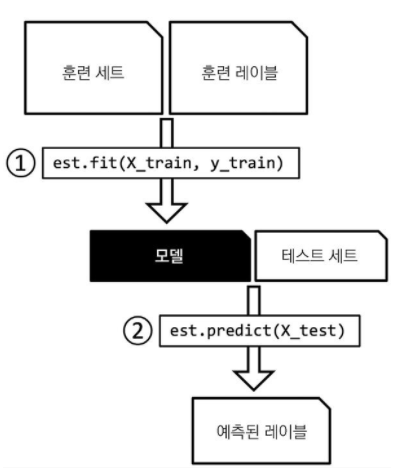

In [32]:
from IPython.display import Image
Image("estimator.png")

### 4.2 범주형 데이터 다루기

#### 4.2.1 순서가 있는 특성과 순서가 없는 특성

순서가 있는 것과 없는 것을 구분해야함
* 예) 순서가 있는 것: 티셔츠 사이즈, 순서가 없는 것: 티셔츠 색깔

In [55]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


#### 4.2.2 순서 특성 매핑

학습 알고리즘이 순서 특성을 올바르게 인식하려면 범주형의 문자열 값을 정수로 바꾸어주어야함 -> 매핑함수 만들기!

In [56]:
size_mapping = {
    'XL': 3, 'L':2, 'M':1
} # 튜플 형태
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


정수 값을 다시 원래 문자열 표현으로 바꾸고 싶다면 거꾸로 매핑하는 딕셔너리 inc_size_mapping={v: k for k, v in size_mapping.items()} 를 정의

In [57]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

#### 4.2.3 클래스 레이블 인코딩

* 사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변환해 주지만 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋은 습관
* 클래스 레이블을 인코딩하려면 순서 특성을 매핑한 것과 비슷한 방식을 사용
* 클래스 레이블은 순서가 없다는 것을 기억
* enumerate를 사용하여 클래스 레이블을 할당

In [58]:
import numpy as np
class_mapping = {label:idx for idx, label in
                enumerate(np.unique(df['classlabel']))}
class_mapping # tuple 형태로 반환

{'class1': 0, 'class2': 1}

그 다음 매핑 딕셔너리를 사용하여 클래스 레이블을 정수로 변환

In [59]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


##### enumerate
* 반복문 사용 시 몇 번째 반복문인지 확인이 필요할 때 사용
* 인덱스 번호와 같은 컬렉션의 원소를 tuple형태로 반환

출처: https://wikidocs.net/16045

In [37]:
t = [1, 5, 7, 33, 39, 52]
for p in enumerate(t):
    print(p)

(0, 1)
(1, 5)
(2, 7)
(3, 33)
(4, 39)
(5, 52)


In [41]:
for i, v in enumerate(t):
    print("index : {}, value: {}".format(i, v))

index : 0, value: 1
index : 1, value: 5
index : 2, value: 7
index : 3, value: 33
index : 4, value: 39
index : 5, value: 52


변환된 클래스 레이블을 다시 원본 문자열로 바꾸기

In [61]:
inv_class_mapping = {v:k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


다른 방법으로 사이킷런에 구현된 LabelEncoder 클래스를 사용하면 편리

In [63]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0], dtype=int64)

##### fit_transform
fit 메서드와 transform 메서드를 합쳐 놓은 단축 메서드
##### inverse_transform
정수 클래스 레이블을 원본 문자열 형태로 되돌리는 메서드

In [64]:
class_le.inverse_transform(y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class1', 'class2', 'class1'], dtype=object)

#### 4.2.4 순서가 없는 특성에 원-핫 인코딩(one-hot encoding) 적용

순서가 없는 color열에도 비슷한 방식(LabelEncoder)을 사용

In [71]:
X = df[['color', 'size', 'price']].values
X

array([['green', 1, 10.1],
       ['red', 2, 13.5],
       ['blue', 3, 15.3]], dtype=object)

In [72]:
# color_le = LabelEncoder()
X[:, 0] = LabelEncoder().fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

##### LabelEncode
* 타깃 렝블을 인코딩하기 위한 클래스이므로 입력 데이터로 1차원 배열을 기대
  * 앞 코드에서 color열만 추출하여 LabelEncoder 객체에 주입한 이유!
* 데이터셋에 변경해야 할 열이 많다면 동일한 작업을 반복해야하므로 번거로움
  * 사이킷런 0.20 버전에서는 범주형 데이터를 정수로 인코딩하는 OrdinalEncoder와 판다스 데이터프레임의 열마다 다른 변환을 적용하도록 도와주는 ColumTransformer가 추가됨
  * 이 두 클래스를 이용하면 여러 개의 열을 한번에 정수로 변환할 수 있음
  
출처: 머신러닝 교과서 with 파이썬 사이킷런, 텐서플로, 세바스찬 라시카, 바히드 미자리리 지음, 박해선 옮김, 146~147쪽

##### 위의 코드의 문제점 !!!
컬러 값에 어떤 순서가 없지만 학습 알고리즘이 red > green > blue 라고 가정<br>
이 가정이 옳지 않지만 알고리즘이 의미 있는 결과를 만들 수 있음<br>
But 최선의 결과가 아님<br>
-> 원-핫 인코딩 기법 사용하여 문제 해결

##### 원-핫 인코딩 (one-hot encoding) 기법
* 순서 없는 특성에 들어 있는 고유한 값마다 새로운 더미 특성을 만듦
* 여기서는 color 특성을 세 개의 새로운 특성인 blue, green, red로 변환하고 이진 값을 사용하여 특정 샘플의 color를 나타냄
  * blue = [ 1, 0, 0 ], green = [ 0, 1, 0 ], red = [0, 0, 1] 

1. OneHotEncoder 사용
  * 변환하려는 특성의 열 위치를 categorical_features 매개변수에 전달
  * OneHotEncoder의 transform 메서드는 희소 행렬)을 반환
  * 희소 행렬: 대부분의 행렬 값이 0인 행렬
    * 대량의 데이터셋을 저장할 때 효율적
    * 배열에 0이 많이 포함되어 있을 때 유용
    * 사이킷런의 많은 함수는 희소 행렬을 지원
  * 배열 내용을 보려면 희소 행렬의 toarray 메서드로 일반(밀집)넘파이 배열로 변환
 

In [78]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe

OneHotEncoder(categorical_features=[0], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [79]:
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

<br>
2. 판다스의 get_dummies 사용
  * 더 편리
  * DataFrame에 적용하면 get_dummies 메서드는 문자열 열만 반환하고 나머지 열은 그대로 둠

In [80]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


주의할 점
* 다중 공신성 문제
  * 어떤 알고리즘에서는 이슈가 될 수 있음(예를 들어 역행렬을 구해야 하는 경우)
  * 특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해짐
  * 변수 간의 상관관계를 감소하기 위해 원-핫 인코딩된 배열에서 특성 열 하나를 삭제
  * 특성을 삭제해도 잃는 정보는 없기 때문에 가능
 <br><br>
* get_dummies를 사용할 때 drop_first 매개변수를 True로 지정하여 첫 번째 열을 삭제
* OneHotEncoder는 열을 삭제하는 매개변수가 없음
  * 원-핫 인코딩된 넘파이 배열을 슬라이싱 할 수 있음

In [83]:
pd.get_dummies(df[['price', 'color', 'size']],
              drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [84]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

### 4.3 데이터셋을 훈련 세트와 테스트 세트로 나누기

In [92]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                     'ml/machine-learning-databases/'
                     'wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthosyanins', 'Color intensity', 'Hue', '0D280/OD315 of diluted wines', 'Proline']
print('클래스 레이블', np.unique(df_wine['Class label']))

클래스 레이블 [1 2 3]


In [93]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthosyanins,Color intensity,Hue,0D280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


사이킷런의 model_selection 모듈에 있는 train_test_split 함수를 사용하면 가장 간편하게 데이터셋을 랜덤한 훈련 세트와 테스트 세트로 나눌 수 있음

In [95]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

##### sklearn의 train_test_split() 사용법
(1) 파라미터
train_test_split(array, test_size, train_size, random_state, suffle, stratify)
* array: 분할시킬 데이터를 입력
* test_size: 테스트 데이터셋의 비율이나 개수(default=0.25)
* train_size: 학습 데이터셋의 비율이나 개수(default=test_size의 나머지)
* shuffle: 셔플여부설정(default=True)
* stratify: 지정한 data의 비율을 유지(훈련 세트와 테스트 세트에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지)
* random_state: 재현가능하도록 난수의 초기값을 설정(아무 숫자나 넣어주면 됨)

(2) 리턴값
* X_train, X_test, Y_train, Y_test: arrays에 데이터와 레이블을 둘 다 넣었을 경우의 반환, 데이터와 레이블의 순서쌍은 유지됨
* X_train, X_test: arrays에 레이블 없이 데이터만 넣었을 경우의 반환

In [100]:
df_wine.iloc[:, 1:].head() # X에 대입된 데이터

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthosyanins,Color intensity,Hue,0D280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [102]:
df_wine.iloc[:, 1:].head().values

array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
        2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00,
        3.240e+00, 3.000e-01, 2.810e+00, 5.680e+00, 1.030e+00, 3.170e+00,
        1.185e+03],
       [1.437e+01, 1.950e+00, 2.500e+00, 1.680e+01, 1.130e+02, 3.850e+00,
        3.490e+00, 2.400e-01, 2.180e+00, 7.800e+00, 8.600e-01, 3.450e+00,
        1.480e+03],
       [1.324e+01, 2.590e+00, 2.870e+00, 2.100e+01, 1.180e+02, 2.800e+00,
        2.690e+00, 3.900e-01, 1.820e+00, 4.320e+00, 1.040e+00, 2.930e+00,
        7.350e+02]])

In [106]:
df_wine.iloc[:, 0].head() # y에 대입된 데이터(클래스레이블)

0    1
1    1
2    1
3    1
4    1
Name: Class label, dtype: int64

#### 4.4 특성 스케일 맞추기

경사하강법 공부하기, k-최근접 이웃 공부하기